In [11]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.append('..')
import ext.minimal_lczero.new_data_pipeline as dp
from IPython.display import display, SVG, clear_output
from pathlib import Path
from tqdm import tqdm
from matplotlib import pyplot as plt
import numpy as np
import chess
import torch
import time
from ext.minimal_lczero.policy_index import policy_index as POLICY_INDEX
from src.leela_data import Lc0Loader, Lc0TeacherDataset
from src.util import save_gif
from src.train import train
from src.leela_cnn import LeelaCNN

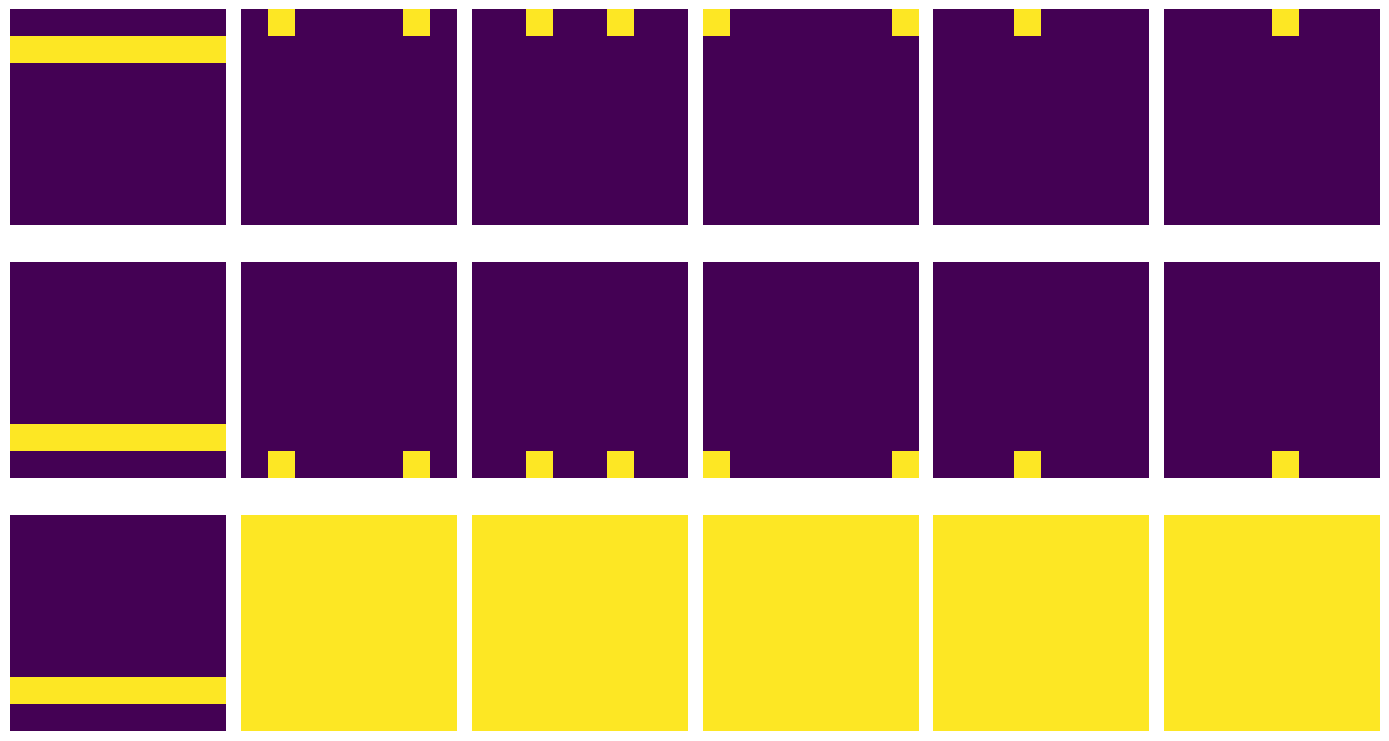

In [15]:

chunk_dir = '/Users/max/ml/chesshacks-training/data/small'
files = list(Path(chunk_dir).glob("*.gz"))
dataset = Lc0TeacherDataset(
    lc0_loader=Lc0Loader(files=files)
)
board, mask, policy, value = next(iter(dataset))
fig, axes = plt.subplots(3, 6, figsize=(14, 8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(
        board[i].numpy(),
        # cmap='gray',
        vmin=0,
        vmax=1,
    )
    ax.axis('off')
plt.tight_layout()
plt.show()

In [13]:
class Loss(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.softmax = torch.nn.Softmax(dim=1)
        self.policy_loss_fn = torch.nn.CrossEntropyLoss(reduction='mean')
        self.value_loss_fn = torch.nn.MSELoss()

    def forward(
        self,
        mask: torch.Tensor,
        policy_pred: torch.Tensor,
        value_pred: torch.Tensor,
        policy_target: torch.Tensor,
        value_target: torch.Tensor,
    ):
        zeros = torch.zeros((policy_pred.shape)).to(mask.device)
        policy_pred = torch.where(mask, policy_pred, zeros)
        policy_target = torch.where(mask, policy_target, zeros)
        policy_loss = self.policy_loss_fn(self.softmax(policy_pred), policy_target)
        value_loss = self.value_loss_fn(value_pred.squeeze(), value_target.squeeze())
        total_loss = policy_loss + value_loss
        return total_loss, policy_loss, value_loss

In [14]:
model = LeelaCNN(
    block_count=10,
    filter_count=128,
)
optim = torch.optim.Adam(model.parameters(), lr=3e-4)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optim, gamma=0.9)

train(
    model_name='LeelaCNN v0.1',
    model=model,
    loss_fn=Loss(),
    optimizer=optim,
    scheduler=scheduler,
    train_set=dataset,
    val_set=dataset,
    batch_size=64,
    num_workers=1,
    epochs=10,
    seed=42,
)


/Users/max/ml/chesshacks-training/.venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py:692: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, device pinned memory won't be used.
  warnings.warn(warn_msg)


KeyboardInterrupt: 